Congratulations on reaching the assignment stage!

On this assignment you will work with a dataset of real life taxi rides and will prepare a basic prediction model, just like we do at Autofleet.

Instructions will be provided as you progress through this notebook.

Please try to be as detailed and descriptive as possible so that we understand your
thought process.

In [1]:
%matplotlib inline
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
from sklearn.metrics import mean_absolute_error
import numpy as np
from tqdm import tqdm

## Load Data

In [2]:
df_rides = pd.read_csv('rides.csv')
df_rides.head()

,RIDE_ID,created_on,created_on_hour,started_on,completed_on,distance_travelled
0,0,2016-06-04 00:10:19,2016-06-04 00:00:00,2016-06-04 00:18:49,2016-06-04 00:27:32,8459.0
1,1,2016-06-04 01:47:39,2016-06-04 01:00:00,2016-06-04 01:50:12,2016-06-04 01:51:49,443.0
2,2,2016-06-04 03:13:07,2016-06-04 03:00:00,2016-06-04 03:16:02,2016-06-04 03:17:57,568.0
3,3,2016-06-04 09:52:35,2016-06-04 09:00:00,2016-06-04 10:05:13,2016-06-04 10:13:38,4051.0
4,4,2016-06-04 10:23:25,2016-06-04 10:00:00,2016-06-04 10:24:25,2016-06-04 10:26:07,790.0


## Data Exploration

In [3]:
df_hourly_rides = df_rides.groupby('created_on_hour')['RIDE_ID'].count().reset_index().rename(columns={'RIDE_ID': 'rides'})
df_hourly_rides['created_on_hour'] = pd.to_datetime(df_hourly_rides['created_on_hour'])
df_hourly_rides.head()


,created_on_hour,rides
0,2016-06-04 00:00:00,1
1,2016-06-04 01:00:00,1
2,2016-06-04 03:00:00,1
3,2016-06-04 09:00:00,1
4,2016-06-04 10:00:00,1


### Task #1

Plot the rides overtime on a daily level. 
Is there any trend?

### Task #1 - Answer

In [4]:
from utils import plot_values_on_daily_level

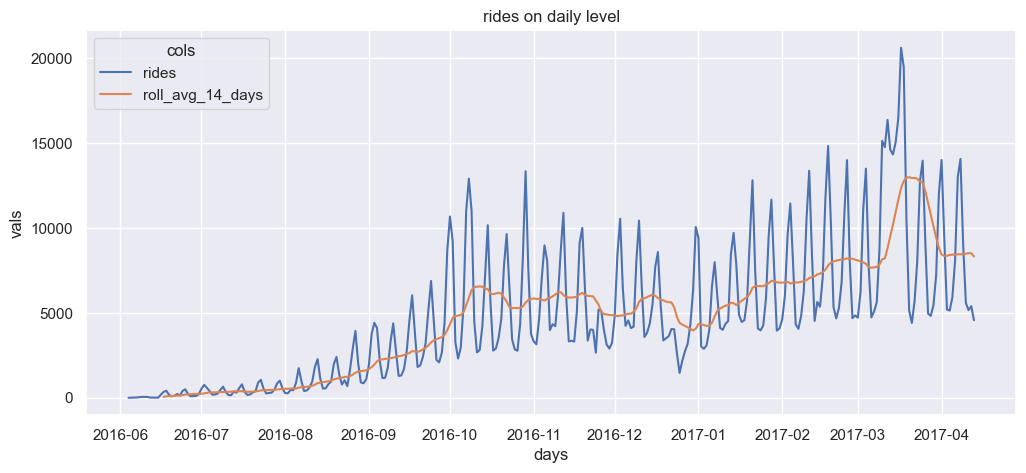

In [5]:
df_daily_rides = plot_values_on_daily_level(df=df_hourly_rides,
                                            value_column='rides',
                                            time_column="created_on_hour",
                                            roll_avg_days=14)

Yes, it appears there is a trend and also seasonality. 
1. First, there is a clear periodicity shown by the amplitudes within intervals of weeks.
2. Second, there is also a clear trend of increasing usage with an interval of almost one year.The orange moving average line is showing this trend clearly.

### Task #2

Plot a ride distance histogram.
What is the distribution? is it normal?

### Task #2 - Answer

Given that the data is quite large, let's take several samples for the histogram and visually check if the distribution significantly changes between samples. 
Afterwards, let's run the Kolmogorov-Smirnov test to test the null hypothesis that the data is not normally distributed.

In [6]:
from utils import sample_and_plot_histogram

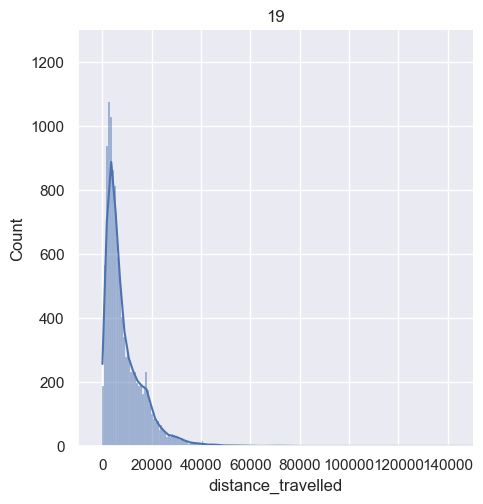

In [9]:
sample_and_plot_histogram(df = df_rides, 
                          per_of_sample  = 0.008,
                          value_columns = "distance_travelled",
                          number_of_samples = 20)

None of the different samples appear to be normal. The main reason is that they do not exhibit properties of a normal distribution, the most obvious being the lack of symmetry. 
Let's test the hypothesis that the data comes from a normal distribution using the Kolmogorov-Smirnov test.

In [10]:
scipy.stats.kstest(df_rides.distance_travelled.dropna(how='all'),
                   scipy.stats.norm.cdf)

KstestResult(statistic=0.9999020691530339, pvalue=0.0, statistic_location=4.0, statistic_sign=-1)

$P_{value} = 0$ indicating that we must reject the null hypothesis that the distance traveled follows a normal distribution.

## Preprocessing

In [11]:
df_times = pd.read_csv('times.csv')
df_times['datetime'] = pd.to_datetime(df_times['datetime'])
df_times.head()

,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour
0,2016-06-04 00:00:00,5,6,4,2016,22,156,False,None,0
1,2016-06-04 01:00:00,5,6,4,2016,22,156,False,None,1
2,2016-06-04 02:00:00,5,6,4,2016,22,156,False,None,2
3,2016-06-04 03:00:00,5,6,4,2016,22,156,False,None,3
4,2016-06-04 04:00:00,5,6,4,2016,22,156,False,None,4


### Task #3

You have time features in the df_times dataframe. 
Merge this dataframe with the hourly rides dataframe, so you can use those features later.

### Task #3 - Answer

In order to prevent from issues when joining the data lets run several queries 



In [12]:
from utils import queries_before_join

##### Running some queries in order to test keys and duplications of the different data sets 

In [13]:
queries_before_join(df_times = df_times, 
                    df_hourly_rides = df_hourly_rides)

Number of unique time points in df_times: 7531

Number of unique time points in df_hourly_rides : 7296

Duplicates in `df_times`: 0

How many out of df_hourly_rides is in df_times ?  7296

Out of the df_times observations, what is the distribution of the times that do not appear in the df_hourly_rides?
 2016-06    202
2016-07     24
2016-08      7
2016-09      1
2017-03      1
Freq: M, Name: datetime, dtype: int64


As it is evident from the above, the df_time object includes all time points present in df_hourly_rides and more. Furthermore, the time points that exist in df_time but not in df_hourly_rides are spread out across months, but the majority of these measurements are related to the beginning of the data. Therefore, let's perform a left join on df_hourly_rides and df_time.

In [14]:
df_hourly_times_rides = pd.merge(df_times, 
                                 df_hourly_rides, 
                                 left_on='datetime', 
                                 right_on='created_on_hour',
                                 how="left")

# Test unchanged df_hourly_rides shape
df_hourly_times_rides.shape

(7531, 12)

Let's plot the missing values distribution

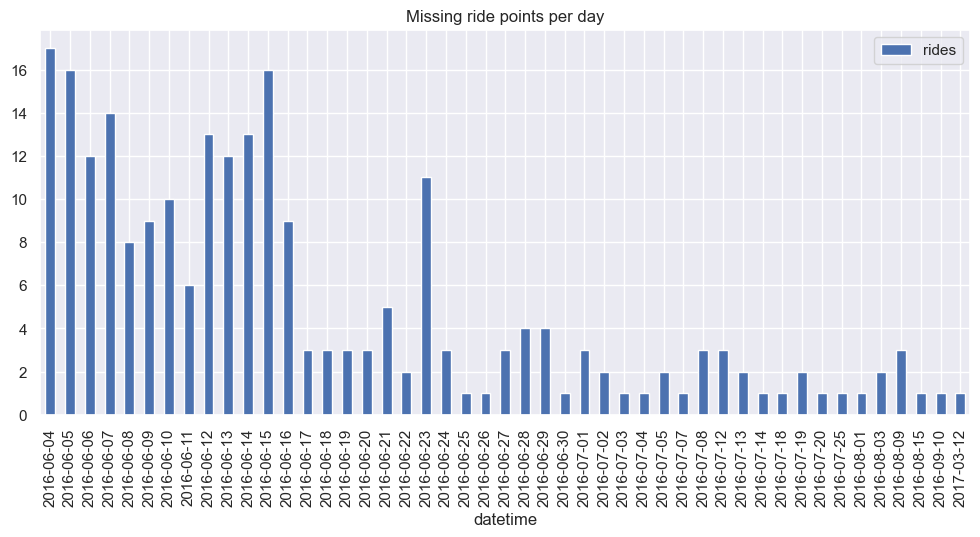

In [15]:
dd = df_hourly_times_rides[df_hourly_times_rides.rides.isna()]
dd.rides = 1
dd.groupby([dd["datetime"].dt.date]).sum().reset_index().plot.bar(x="datetime",
                                                                  y = "rides",
                                                                  title= 'Missing ride points per day');

After joining, it is clear that there are missing `rides` points across the data. 

We will need to take this issue into account during the modeling process.

### Task #4

We would like to add a lag feature, which retrieves the amount of rides taken at the same exact hour last week. 
Please implement this feature.
What is the correlation between current and last week's rides?

### Task #4 - Answer

The function below calculates and adds lag columns based on the specified time unit and interval

In [16]:
from utils import add_time_unit_lag

In [17]:
df_hourly_times_rides = add_time_unit_lag(df = df_hourly_times_rides, 
                                          value_column  = 'rides',
                                          time_unit ='d', 
                                          lag = 7)

In [18]:
df_hourly_times_rides[["datetime","rides","rides_last_d_7"]].tail(10)

,datetime,rides,rides_last_d_7
7521,2017-04-13 09:00:00,282.0,357.0
7522,2017-04-13 10:00:00,288.0,304.0
7523,2017-04-13 11:00:00,277.0,265.0
7524,2017-04-13 12:00:00,259.0,288.0
7525,2017-04-13 13:00:00,295.0,294.0
7526,2017-04-13 14:00:00,310.0,318.0
7527,2017-04-13 15:00:00,350.0,352.0
7528,2017-04-13 16:00:00,401.0,388.0
7529,2017-04-13 17:00:00,441.0,477.0
7530,2017-04-13 18:00:00,417.0,614.0


#### Calculating correlation 

We can easily calculate the correlation by using the built-in 'corr' function in pandas.

In [19]:
df_hourly_times_rides[["rides","rides_last_d_7"]].corr().iloc[0:1,1:2]

,rides_last_d_7
rides,0.832631


The correlation is quite high, at 0.83. This suggests that the same hour from last week could be a valuable feature for our final model. However, before making any conclusions, let's test the correlation between the target variables and other back legs.

In [20]:
for time, lag in [('d',14),('d',3),('h',12),('h',5),('h',32)]:
    df_i = add_time_unit_lag(df = df_hourly_times_rides, 
                             time_unit =time, 
                             lag = lag,
                             value_column = 'rides')
    print(df_i[["rides",f"rides_last_{time}_{lag}"]].corr().iloc[0:1,1:2],'\n')
    

       rides_last_d_14
rides         0.799237 

       rides_last_d_3
rides        0.296375 

       rides_last_h_12
rides         0.274643 

       rides_last_h_5
rides        0.547048 

       rides_last_h_32
rides          0.25062 



It seems that there is a significant correlation (0.79) when looking at a lag of two weeks back, whereas other random lags have a lower correlation. This implies that the results are reasonable.

## Model

### Task #5

We would like to predict how many rides will occur every hour.

As a first step, propose a simple baseline and measure its MAE (mean absolute error)

### Task #5 - Answer

Let's create two naive baselines.

1. One in which we are not allowed to use any data outside of the test set at all. 
    1. A good use case for this would be a business that makes predictions a month in advance. 
    2. The assumption in this case is that the business **cannot respond** quickly to predictions on short intervals. 


2. In the second baseline, we are allowed to use all data up until N hour before. 
    1. This would be useful for a dynamic business that quickly adjusts to changes in the environment. 
    2. The assumption in this case is that the business **can respond** quickly to predictions on short intervals.


For both of our baselines, we are not accounting for missing values because all of our calculations are based on "time intervals" rather than rows intervals. For instance, when calculating the average, missing points will not be included in the calculation and no other data points will be used as a replacement.


The assumption behind these baselines is that there is a high correlation between the same or close hours preceding the predicted point. Additionally, it is assumed that even if there are some missing points for prediction generation, there will still be enough points for the calculations. 

In [21]:
df = df_hourly_times_rides[:]

### First basline 
In this baseline, we are not allowed to use any data after 2017-03-30 and we are also ignoring all other features except for historical rides per day of the week and hour. So, we are going to use the average rides per hour and day of the week for the 4 weeks prior. Of course, it is possible to create more 'smart' baselines, such as Search for bttter interval back, assigning higher weights for closer dates or even taking trends into account.

#### Train test split 

In [22]:
days_back_range = 28
test = df[(df.datetime >= '2017-03-30 00:00:00') & (df.datetime < '2017-04-13 00:00:00')]
train = df[(df.datetime >= test.datetime.min() - pd.Timedelta(days=days_back_range)) &\
           (df.datetime < test.datetime.min())]

###### Fit and predict 

Calculating the average per day-of-week_hour and assigning it to the equivalent point in the test set.

In [23]:
from utils import fit_predict_baseline_a

In [24]:
df_actual_vs_pred = fit_predict_baseline_a(df_fit = train, 
                                           df_predict = test, 
                                           groupby_cols = ['weekday', 'hour'], 
                                           value_col = "rides")

##### Evaluating with MAE

In [25]:
mean_absolute_error(df_actual_vs_pred.actual,
                    df_actual_vs_pred.predicted)

104.53174603174605

###### Plot of predicted vs actual 

In [26]:
from utils import plot_predicted_vs_actual

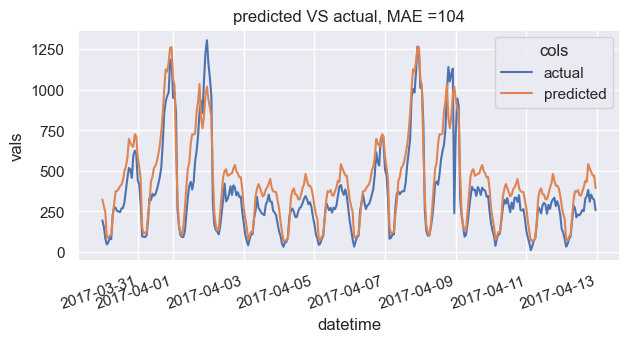

In [27]:
plot_predicted_vs_actual(df = df_actual_vs_pred,
                         fig_size = (7,3))

It appears that in terms of seasonality, baseline_a is catching the weekly and daily patterns. However, it is also clear that it tends to over-predict demands most of the time. The main reason for this is its lack of capturing the overall monthly trend. By taking a simple mean of hours and days of the last month, it completely ignores changes in trends in the new month. 

Another limitation of this baseline is its poor performance in predicting peaks and drops, which may be due to the following reasons: 
1. It completely ignores other features such as day types (holidays, etc.) 
2. It does not use daily/hourly trend features.

Of course, we can improve this baseline in terms of MAE by adding more features (such as special days, trends, etc.) or by performing a grid search for a better interval of lag history, as demonstrated in the following example.

In [28]:
from utils import plot_predicted_vs_actual_for_different_intervals

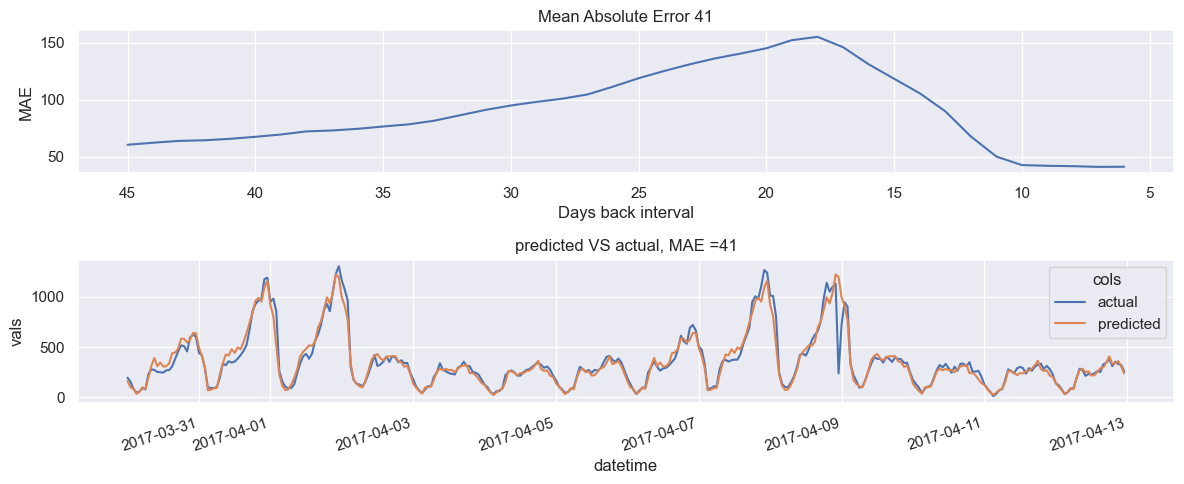

In [32]:
days_back_range = 46

best_mae = plot_predicted_vs_actual_for_different_intervals(df = df, 
                                                            test = test, 
                                                            days_back_range = days_back_range,
                                                            groupby_cols = ['weekday', 'hour'],
                                                            value_col = "rides")

the best MAE os for interval of looking 8 days back

In [33]:
best_mae

{'best_mae': 41.00297619047619, 'best_mae_interval': 8}

### Seconde baseline 

For this baseline, in order to generate a prediction for point $n$, we will average all previous points from $n-1$ to $n-k$.

The assumptions for this approach are:

1. There are k last points for all test points (less than k missing values or NaNs)
2. Using all data up until the last hour is aligned with business logic, meaning that this short-term prediction is valuable for the business as it is able to act accordingly to this short-term.


In this approach, we will not be using additional features.

In [34]:
from utils import fit_predict_baseline_b

###### Fit and predict 

Lets fit and predict in interval of 4 hours back

In [35]:
mae,df_actual_vs_pred = fit_predict_baseline_b(df = df, 
                                               df_predict = test, 
                                               k_last_hours = 4, 
                                               value_col = "rides")

mae

117.55803571428571

As before, in order to take a closer look and examine how we can improve the baseline, we can perform a grid search for different intervals.

In [36]:
from utils import plot_predicted_vs_actual_for_different_intervals_bl_b

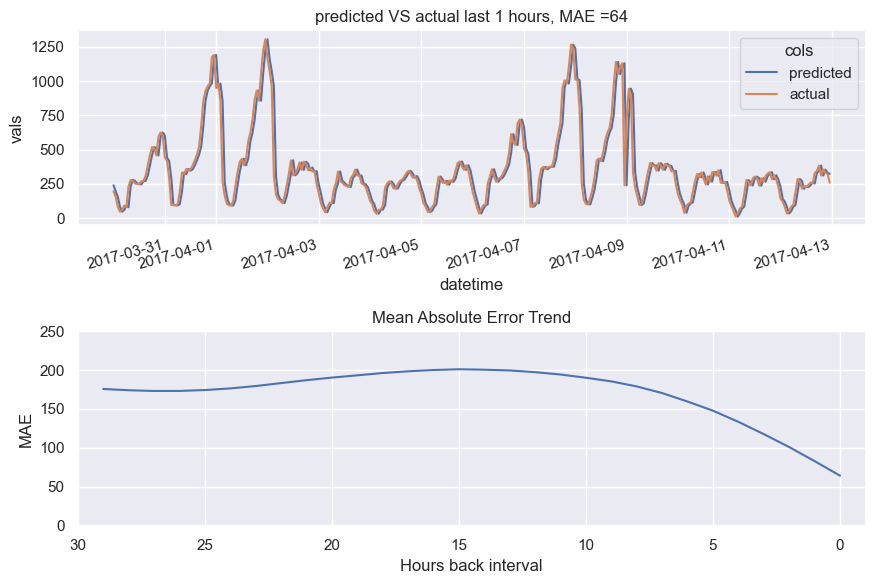

In [38]:
hours_back_range = 30
best_mae = plot_predicted_vs_actual_for_different_intervals_bl_b(df = df,
                                                                  test = test,
                                                                  hours_back_range = hours_back_range,
                                                                  value_col = "rides")

the best MAE os for interval of looking 1 hour back

In [181]:
best_mae

{'best_mae': 64.05059523809524, 'best_mae_interval': 1}

As it is clearly shown, for the given baseline technique, using the last hour value as a predictor for the next hour results in minimal error. However, in many cases, we need to generate predictions earlier, because in reality, there are many constraints that do not allow for such short-term predictions. For example, it is impossible to move taxis between areas, such as cities (Tel-Aviv to Hifa),in the morning in Israel."

### Task #6

Now let's create a model and calculate its performance.

Is it better than the baseline?

**Use the same test set from previous task**.

### Task #6 - Answer


Here we will target this section by two ways : 
1. A regulare mechine learning approach
2. Time series approach 

A **regular machine** learning approach treats data as independent observations, whereas a time series approach takes into account the temporal ordering of the data points.In a regular machine learning approach, the model is trained on a set of input-output pairs, and the goal is to learn a mapping from the inputs to the outputs.

In a **time series** problem, the observations are not independent of each other, and the future values are dependent on the past values. This temporal correlation between the observations needs to be considered while modeling the data.
in a time series problem, the goal is to model the underlying patterns and trends in the data, and to use these patterns to make predictions about future values.

##### A note:

Before beginning the modeling process, we will drop the first few months (starting from `2016-08-03 04:00:00`)of data which contain a large number of missing target variables. There may be more "smarter" ways to handle these missing points, but we will leave it for further research. 

In [22]:
df = df_hourly_times_rides[(df_hourly_times_rides.datetime > '2016-08-03 04:00:00') & \
                           (df_hourly_times_rides.datetime < '2017-04-13 00:00:00')]


## regular ML approach

Here we will demonstrate how to approach this problem as a regular machine learning problem. This means we will:

1. Utilize features that were not used in the previous baselines.
2. Manually calculate additional features from our data.
3. Select an algorithm (such as catboost) that is capable of handling a variety of different features.
4. Remove rows with missing target values

##### data processing

Here we will demonstrate a simple data processing technique. 

The following function will:

1. Calculate new features such as the number of rides for a given time period in the past and the average number of rides over a specific time period. These calculations are done dynamically, allowing us to control the number of features and the time intervals used.
2. Convert the features to categorical variables.
3. Remove any missing values from the target variable.

In [23]:
from utils import data_processing_ml_approach

##### Define proccesing parameters 

1. Categorical columns - These are the columns that we will convert to categorical data types.
2. Lag features - We will calculate lag features with respect to a specific time unit and interval. For example, ("d",2) means the same hour two days back.
3. Avg feature - Averaging last n data points - We will calculate the average of the last n data points with respect to a specific time unit and interval. For example, ("h",8) means the average of the last 8 hours."

In [24]:
cat_cols = ['weekday','hour','us_holiday_type']
lag_features = [("h",1),("h",24),("d",2)]
avg_features =[(4,'h'),(8,'h')]

In [25]:
df_ml = data_processing_ml_approach(df = df,
                                     cat_cols = cat_cols,
                                     value_column = 'rides',
                                     lag_features = lag_features,
                                     avg_features =avg_features)

### Train test split 

In [26]:
split_value  = '2017-03-30 00:00:00'
test = df_ml[df_ml.datetime >= split_value]
train = df_ml[(df_ml.datetime < split_value)] 

##### Choos features

Some features were left out because they did not provide direct information that could be learned by the model, such as `datetime` features. Additionally, some features were not included in the current configuration as they did not contribute to the model's performance, such as `weekofyear` and `dayofyear`, since we only have data from one year. In future iterations, we can add, test, and choose different features by using more advanced feature selection techniques, such as examining feature importance, using SHAP, or analyzing feature weights."





In [27]:
y = 'rides'
X = ['weekday', 
     'us_holiday', 
     'us_holiday_type', 
     'hour',
     'rides_last_d_7',
     'rides_last_h_1',
     'rides_last_h_24',
     'rides_last_d_2', 
     'roll_avg_4h_', 
     'roll_avg_8h_']

##### Assigning features and target columns

In [28]:
X_train = train[X]
y_train = train[y]
X_test = test[X]
y_test = test[y]

### Training

Importing and itiating the catboot classs

In [29]:
from catboost import CatBoostRegressor
model = CatBoostRegressor()


Fiting the model

In [30]:
model.fit(X_train, 
          y_train,



Learning rate set to 0.05394
0:	learn: 230.9088047	total: 59.4ms	remaining: 59.3s
1:	learn: 220.3744985	total: 62.6ms	remaining: 31.3s
2:	learn: 210.5154180	total: 65.9ms	remaining: 21.9s
3:	learn: 201.4509365	total: 68.7ms	remaining: 17.1s
4:	learn: 192.9015081	total: 71.7ms	remaining: 14.3s
5:	learn: 184.6807823	total: 74.3ms	remaining: 12.3s
6:	learn: 176.7336335	total: 77.1ms	remaining: 10.9s
7:	learn: 169.3307774	total: 79.8ms	remaining: 9.9s
8:	learn: 162.4922221	total: 82.4ms	remaining: 9.07s
9:	learn: 156.1878259	total: 84.8ms	remaining: 8.39s
10:	learn: 150.1286077	total: 87.1ms	remaining: 7.83s
11:	learn: 144.2956462	total: 89.4ms	remaining: 7.36s
12:	learn: 138.9475828	total: 92.1ms	remaining: 6.99s
13:	learn: 133.8761906	total: 94.6ms	remaining: 6.67s
14:	learn: 129.1565339	total: 96.9ms	remaining: 6.36s
15:	learn: 124.6373527	total: 99.1ms	remaining: 6.1s
16:	learn: 120.4375861	total: 101ms	remaining: 5.86s
17:	learn: 116.3582883	total: 103ms	remaining: 5.63s
18:	learn: 11

164:	learn: 50.8727765	total: 389ms	remaining: 1.97s
165:	learn: 50.8513660	total: 391ms	remaining: 1.97s
166:	learn: 50.8070686	total: 393ms	remaining: 1.96s
167:	learn: 50.7363663	total: 396ms	remaining: 1.96s
168:	learn: 50.7030198	total: 398ms	remaining: 1.96s
169:	learn: 50.6589299	total: 400ms	remaining: 1.95s
170:	learn: 50.6245405	total: 402ms	remaining: 1.95s
171:	learn: 50.5748862	total: 405ms	remaining: 1.95s
172:	learn: 50.5484808	total: 406ms	remaining: 1.94s
173:	learn: 50.5007793	total: 409ms	remaining: 1.94s
174:	learn: 50.3446895	total: 411ms	remaining: 1.94s
175:	learn: 50.2189189	total: 413ms	remaining: 1.93s
176:	learn: 50.1179463	total: 415ms	remaining: 1.93s
177:	learn: 50.0564622	total: 417ms	remaining: 1.92s
178:	learn: 50.0510588	total: 419ms	remaining: 1.92s
179:	learn: 49.9905620	total: 422ms	remaining: 1.92s
180:	learn: 49.9074307	total: 424ms	remaining: 1.92s
181:	learn: 49.8246353	total: 427ms	remaining: 1.92s
182:	learn: 49.7643224	total: 429ms	remaining:

365:	learn: 41.3419869	total: 783ms	remaining: 1.36s
366:	learn: 41.2587599	total: 785ms	remaining: 1.35s
367:	learn: 41.2222886	total: 787ms	remaining: 1.35s
368:	learn: 41.1819189	total: 789ms	remaining: 1.35s
369:	learn: 41.1698174	total: 791ms	remaining: 1.35s
370:	learn: 41.1019412	total: 793ms	remaining: 1.34s
371:	learn: 41.0695822	total: 795ms	remaining: 1.34s
372:	learn: 41.0277117	total: 797ms	remaining: 1.34s
373:	learn: 40.9789117	total: 799ms	remaining: 1.34s
374:	learn: 40.9519538	total: 801ms	remaining: 1.33s
375:	learn: 40.9213299	total: 803ms	remaining: 1.33s
376:	learn: 40.8664517	total: 805ms	remaining: 1.33s
377:	learn: 40.8333438	total: 807ms	remaining: 1.33s
378:	learn: 40.7765055	total: 809ms	remaining: 1.32s
379:	learn: 40.7487692	total: 811ms	remaining: 1.32s
380:	learn: 40.6818249	total: 813ms	remaining: 1.32s
381:	learn: 40.6717389	total: 814ms	remaining: 1.32s
382:	learn: 40.6574096	total: 816ms	remaining: 1.31s
383:	learn: 40.6230151	total: 818ms	remaining:

554:	learn: 35.3465368	total: 1.18s	remaining: 945ms
555:	learn: 35.3248294	total: 1.18s	remaining: 943ms
556:	learn: 35.3147011	total: 1.18s	remaining: 941ms
557:	learn: 35.2744006	total: 1.19s	remaining: 939ms
558:	learn: 35.2387260	total: 1.19s	remaining: 937ms
559:	learn: 35.2003160	total: 1.19s	remaining: 935ms
560:	learn: 35.1813214	total: 1.19s	remaining: 933ms
561:	learn: 35.1517447	total: 1.2s	remaining: 931ms
562:	learn: 35.1233005	total: 1.2s	remaining: 929ms
563:	learn: 35.0914748	total: 1.2s	remaining: 928ms
564:	learn: 35.0716509	total: 1.2s	remaining: 926ms
565:	learn: 35.0098659	total: 1.21s	remaining: 924ms
566:	learn: 34.9835219	total: 1.21s	remaining: 922ms
567:	learn: 34.9563101	total: 1.21s	remaining: 920ms
568:	learn: 34.9403410	total: 1.21s	remaining: 918ms
569:	learn: 34.9056443	total: 1.21s	remaining: 916ms
570:	learn: 34.8854867	total: 1.22s	remaining: 914ms
571:	learn: 34.8633021	total: 1.22s	remaining: 913ms
572:	learn: 34.8505824	total: 1.22s	remaining: 911

737:	learn: 31.9898261	total: 1.57s	remaining: 556ms
738:	learn: 31.9615857	total: 1.57s	remaining: 554ms
739:	learn: 31.9527145	total: 1.57s	remaining: 552ms
740:	learn: 31.9171423	total: 1.57s	remaining: 550ms
741:	learn: 31.9066022	total: 1.58s	remaining: 548ms
742:	learn: 31.8580815	total: 1.58s	remaining: 546ms
743:	learn: 31.8378570	total: 1.58s	remaining: 544ms
744:	learn: 31.8287601	total: 1.58s	remaining: 542ms
745:	learn: 31.8130742	total: 1.58s	remaining: 540ms
746:	learn: 31.7996686	total: 1.59s	remaining: 537ms
747:	learn: 31.7783149	total: 1.59s	remaining: 535ms
748:	learn: 31.7665783	total: 1.59s	remaining: 533ms
749:	learn: 31.7485144	total: 1.59s	remaining: 531ms
750:	learn: 31.7292129	total: 1.59s	remaining: 529ms
751:	learn: 31.7013961	total: 1.6s	remaining: 527ms
752:	learn: 31.6922402	total: 1.6s	remaining: 525ms
753:	learn: 31.6608626	total: 1.6s	remaining: 522ms
754:	learn: 31.6496963	total: 1.6s	remaining: 520ms
755:	learn: 31.6210834	total: 1.6s	remaining: 518m

937:	learn: 29.0907230	total: 1.96s	remaining: 129ms
938:	learn: 29.0858899	total: 1.96s	remaining: 127ms
939:	learn: 29.0679520	total: 1.96s	remaining: 125ms
940:	learn: 29.0583537	total: 1.96s	remaining: 123ms
941:	learn: 29.0514511	total: 1.96s	remaining: 121ms
942:	learn: 29.0513295	total: 1.97s	remaining: 119ms
943:	learn: 29.0423988	total: 1.97s	remaining: 117ms
944:	learn: 29.0373518	total: 1.97s	remaining: 115ms
945:	learn: 29.0325125	total: 1.97s	remaining: 113ms
946:	learn: 29.0244707	total: 1.97s	remaining: 110ms
947:	learn: 29.0135844	total: 1.98s	remaining: 108ms
948:	learn: 29.0131774	total: 1.98s	remaining: 106ms
949:	learn: 28.9949916	total: 1.98s	remaining: 104ms
950:	learn: 28.9832983	total: 1.98s	remaining: 102ms
951:	learn: 28.9648188	total: 1.98s	remaining: 100ms
952:	learn: 28.9385591	total: 1.99s	remaining: 97.9ms
953:	learn: 28.9198050	total: 1.99s	remaining: 95.9ms
954:	learn: 28.9023088	total: 1.99s	remaining: 93.8ms
955:	learn: 28.8922523	total: 1.99s	remaini

##### Evaluation

In [31]:
# Get predictions
y_train_pred = model.predict(X_train)

Calculating the MAE


In [32]:
mean_absolute_error(y_train_pred, y_train)

20.238049932459393

The results are much better compared to the baseline results. An interesting question to consider is, what is the source of these improved results? By analyzing the "feature importance" of the model, we can gain a better understanding of the factors that contributed to the improved performance.

In [33]:
from utils import plot_feature_importance

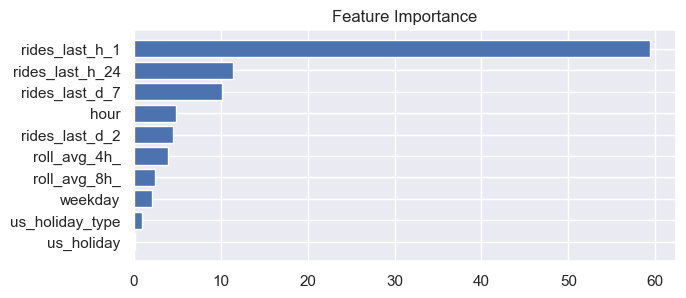

In [34]:
plot_feature_importance(model = model, X_test =X_test)

It is clear that the feature "last hour" had the highest contribution to these results. However, this is also a limitation of the model, as it may not perform as well when predicting earlier time-frames, which may not be suitable for businesses that require early predictions.

# Seconde approche - Time series approch

In this approach, we would use methods specifically designed for sequence modeling. This kind of approach should reduce the need for feature engineering, as it aims to estimate the output directly from sequential data. One example of this approach is using a Vanilla LSTM. However, for more long-term research, we may be interested in exploring more specific architectures, parameters, or even more advanced models such as `neuralprophet`.

Contrary to the previous approach, here we cannot simply remove rows with missing values, as the model does not assume independence between points. For missing target points, we will impute by using the last value. There may be more sophisticated techniques for imputing these missing values, but for the purpose of this research, we will leave it for further investigation.

**Note**: Although we have the option to add additional features such as `day of week` or vacation time, or calculate the lag and average feature in order to help the model converge, for this initial iteration, we will ignore these features in order to see how well the algorithm is able to capture patterns in the data on its own

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [41]:
df_lstm = df[:]

##### data processing

Here we will demonstrate a simple data processing technique.

The following code lines will:

1. Imput missing values by using the last value
2. Convert to float(32) for making it fit for Tensorflow training
3. Normalize the data between 0 to 1 for better convergence
4. Split the data into training and testing sets
5. Organize the data in a way that each target corresponds to the previous 5 points.
6. Reshape the data

In [42]:
from utils import create_dataset

In [61]:
# Asing last value for missing values 
df_lstm = df_lstm.fillna(method='ffill')
df_lstm = df_lstm[(df_lstm.datetime > '2016-08-03 04:00:00') & (df_lstm.datetime < '2017-04-13 00:00:00')]

# fix random seed for reproducibility
tf.random.set_seed(7)

# Data type conversion
dataset = df_lstm[['rides']].values.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_trns = scaler.fit_transform(dataset)


# # Train test split 
min_datetetime = '2017-03-30 00:00:00'
test =  dataset_trns[(df_lstm.datetime >= min_datetetime) ]
train = dataset_trns[ df_lstm.datetime < min_datetetime]


# reshape into X=t and Y=t+1
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

###### Define model

The architecture of this network features a single input in the visible layer, 6 LSTM neurons in the hidden layer, and a final output layer that generates a single prediction. The LSTM blocks utilize the sigmoid activation function as their default. 

In [62]:
# create and fit the LSTM network
input_dim = 1
model = Sequential()
model.add(LSTM(6, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

##### Train 

The training process involves 20 iterations and a batch size of 1 is applied.

In [63]:
history = model.fit(trainX, trainY, epochs=40, batch_size=1, verbose=2,validation_split=0.1,)

Epoch 1/40
5151/5151 - 6s - loss: 0.0021 - val_loss: 0.0025 - 6s/epoch - 1ms/step
Epoch 2/40
5151/5151 - 5s - loss: 0.0012 - val_loss: 0.0035 - 5s/epoch - 890us/step
Epoch 3/40
5151/5151 - 4s - loss: 0.0011 - val_loss: 0.0021 - 4s/epoch - 872us/step
Epoch 4/40
5151/5151 - 4s - loss: 0.0010 - val_loss: 0.0024 - 4s/epoch - 856us/step
Epoch 5/40
5151/5151 - 4s - loss: 9.8204e-04 - val_loss: 0.0022 - 4s/epoch - 856us/step
Epoch 6/40
5151/5151 - 4s - loss: 9.8165e-04 - val_loss: 0.0027 - 4s/epoch - 870us/step
Epoch 7/40
5151/5151 - 5s - loss: 9.5001e-04 - val_loss: 0.0020 - 5s/epoch - 877us/step
Epoch 8/40
5151/5151 - 4s - loss: 9.3817e-04 - val_loss: 0.0026 - 4s/epoch - 867us/step
Epoch 9/40
5151/5151 - 5s - loss: 9.3994e-04 - val_loss: 0.0019 - 5s/epoch - 880us/step
Epoch 10/40
5151/5151 - 5s - loss: 9.2250e-04 - val_loss: 0.0022 - 5s/epoch - 884us/step
Epoch 11/40
5151/5151 - 5s - loss: 9.1006e-04 - val_loss: 0.0020 - 5s/epoch - 889us/step
Epoch 12/40
5151/5151 - 5s - loss: 9.1296e-04 - 

#### Investigating the learning process 

In [64]:
from utils import plot_history

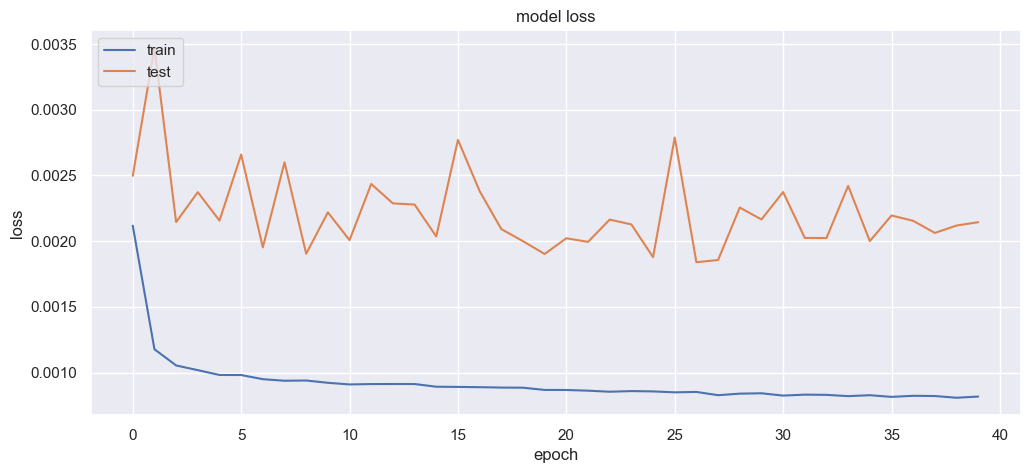

In [65]:
plot_history(history = history)

##### Evaluation

In [66]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

11/11 [==============================] - 0s 914us/step


In [67]:
# Rescaling to base units 
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Calculating MAE

In [68]:
mean_absolute_error(testY[0], testPredict[:,0])

56.535359875730045

As it shown, the results are much

In [124]:
from utils import plot_predicte_vs_actual

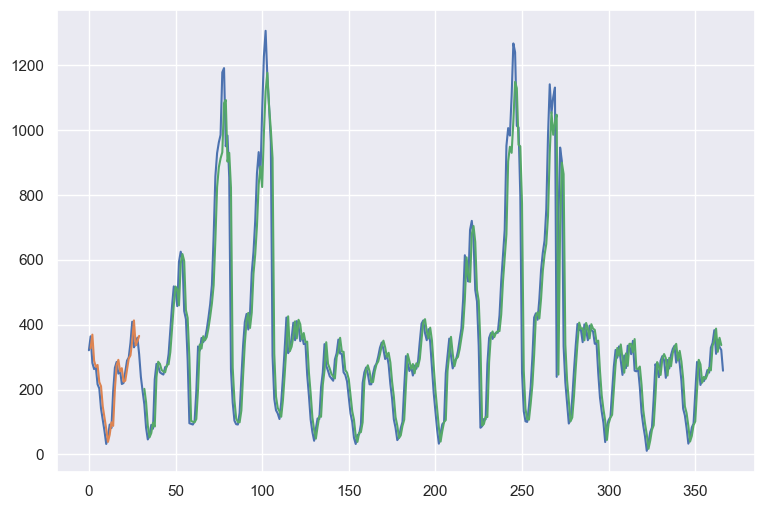

In [125]:
plot_predicte_vs_actual(dataset = dataset[5700:,:], 
                        trainPredict = trainPredict[5700:,:], 
                        testPredict = testPredict , 
                        look_back=1)

### Task #7

You've been offered to purchase an extension of this historical dataset going further into the past. In order to decide whether it is worthwhile, you need to estimate if there's a potential to improve the model given this data.

What is your estimation and why?

#### Answer 
One effective method to determine if additional data can improve our performance is to observe the trend of our primary metric over past intervals.
To accomplish this, we will initially utilize the catboost model as it is efficient, but for feature exploration, we may also consider other models and approachs.
For instance, using the LSTM model here could be reasonable as neural network models tend to show an improvement in performance with an increase in data.

In [74]:
mae_history = []

test = df_ml[df_ml.datetime >= split_value]
train = df_ml[(df_ml.datetime < split_value)] 

X_test = test[X]
y_test = test[y]

for back_interval in tqdm(range(10,train.shape[0],60)):
    
    # Adding more data for each interval
    train_i = train[(train.datetime >= test.datetime.min() - pd.Timedelta(days=back_interval)) &\
                    (train.datetime < test.datetime.min())]


    # Define train feature and target
    X_train = train_i[X]
    y_train = train_i[y]

    # Init class 
    model = CatBoostRegressor()
    
    # Training model 
    model.fit(X_train, 
              y_train,
              cat_features=cat_cols,
              verbose=False)

    #Evaluating on test 
    y_test_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test_pred, y_test)

    mae_history.append(mae)


100%|███████████████████████████████████████████| 96/96 [03:46<00:00,  2.36s/it]


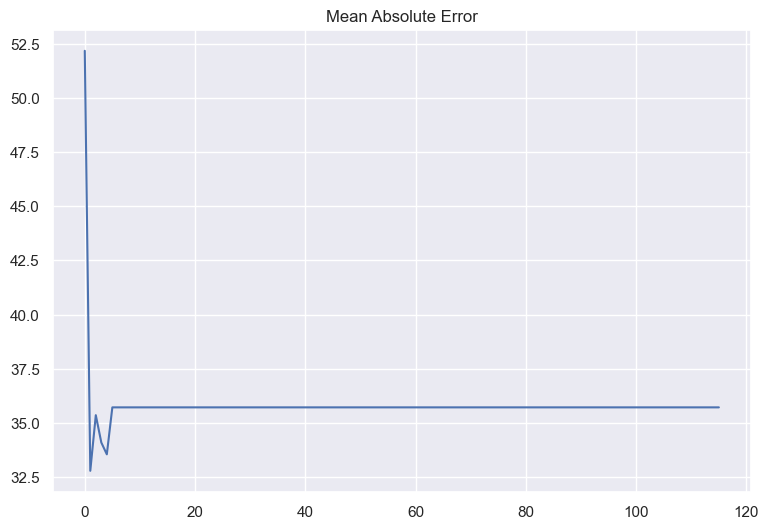

In [163]:
fig, ax =plt.subplots(1,1)
ax.plot(mae_history)
ax.set_title("Mean Absolute Error")
ax.xlabel("Iteration number")
ax.ylabel("MAE")
plt.show()

It is evident from the analysis that the inclusion of additional historical data does not appear to have a significant impact on the performance of the model beyond a lag period of approximately 10 days. This observation holds true for the current set of features and the Catboost algorithm utilized in this study. While it is possible that the inclusion of additional data may lead to improved performance for other types of features or models, it is important to note that the results of this specific study do not support such a conclusion.  For instance, models based on neural networks often demonstrate improved performance with increased data.